# Do some imports

In [1]:
!pip install --user pandas
!pip install --user scikit-learn
!pip install --user tqdm

#do not change this order
import onnx 
import torch 

from typing import List
import numpy as np
from numpy import genfromtxt
import pandas as pd
#

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

from brevitas.nn import QuantIdentity, QuantConv2d, QuantReLU, QuantLinear, QuantHardTanh
from brevitas.core.quant import QuantType

from dataloader import UNSW_NB15
from dataloader_quantized import UNSW_NB15_quantized

### Inspired by [this github file](https://github.com/alik604/cyber-security/blob/master/Intrusion-Detection/UNSW_NB15%20-%20Torch%20MLP%20and%20autoEncoder.ipynb)

# Get UNSW_NB15 train and test set

In [2]:
#!wget https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/a%20part%20of%20training%20and%20testing%20set/UNSW_NB15_training-set.csv

In [3]:
#!wget https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/a%20part%20of%20training%20and%20testing%20set/UNSW_NB15_testing-set.csv

In [4]:
from dependencies import value

from brevitas.inject import BaseInjector as Injector
from brevitas.core.bit_width import BitWidthImplType
from brevitas.core.quant import QuantType
from brevitas.core.restrict_val import RestrictValueType
from brevitas.core.scaling import ScalingImplType

class CommonQuant(Injector):
    bit_width_impl_type = BitWidthImplType.CONST
    scaling_impl_type = ScalingImplType.CONST
    restrict_scaling_type = RestrictValueType.FP
    scaling_per_output_channel = False
    narrow_range = True
    signed = True

    @value
    def quant_type(bit_width):
        if bit_width is None:
            return QuantType.FP
        elif bit_width == 1:
            return QuantType.BINARY
        else:
            return QuantType.INT


class CommonWeightQuant(CommonQuant):
    scaling_const = 1.0


class CommonActQuant(CommonQuant):
    min_val = -1.0
    max_val = 1.0

In [5]:
# Define the Neural Network class
weight_bit_width = 1
act_bit_width = 1

class QuantLeNet(nn.Module):
    def __init__(self, input_size,hidden1, hidden2, hidden3, num_classes):
        super(QuantLeNet, self).__init__()
        self.fc1   = QuantLinear(input_size, hidden1, bias=False, weight_bit_width=weight_bit_width, weight_quant=CommonWeightQuant)
        self.batchnorm1 = nn.BatchNorm1d(hidden1)
        self.identity1 = QuantIdentity(act_quant=CommonActQuant, bit_width=act_bit_width)
        
        self.fc2   = QuantLinear(hidden1, hidden2, bias=False, weight_bit_width=weight_bit_width, weight_quant=CommonWeightQuant)
        self.batchnorm2 = nn.BatchNorm1d(hidden2)
        self.identity2 = QuantIdentity(act_quant=CommonActQuant, bit_width=act_bit_width)
        
        self.fc3   = QuantLinear(hidden2, hidden3, bias=False, weight_bit_width=weight_bit_width, weight_quant=CommonWeightQuant)
        self.batchnorm3 = nn.BatchNorm1d(hidden3)
        self.identity3 = QuantIdentity(act_quant=CommonActQuant, bit_width=act_bit_width)
        
        self.fc4   = QuantLinear(hidden3, num_classes, bias=False, weight_bit_width=weight_bit_width, weight_quant=CommonWeightQuant)
        self.batchnorm4 = nn.BatchNorm1d(num_classes)       


    def forward(self, x):
        fc1 = self.fc1(x)
        b1 = self.batchnorm1(fc1)
        identity1 = self.identity1(b1)
        
        fc2 = self.fc2(identity1)
        b2 = self.batchnorm2(fc2)
        identity2 = self.identity2(b2)

        fc3 = self.fc3(identity2)
        b3 = self.batchnorm3(fc3)
        identity3 = self.identity3(b3)
        
        fc4 = self.fc4(identity3)
        b4 = self.batchnorm4(fc4)
    
        return b4


### Define Train,   Test   and    Display_Loss_Plot    methods

In [6]:
def train(model, device, train_loader, optimizer, criterion):
    losses = []
    model.train()
    y_true = []
    y_pred = []
    
    for i, data in enumerate(train_loader, 0):        
        # get the inputs; data is a list of [inputs, target ( or labels)]
        inputs , target = data
        optimizer.zero_grad()   
                
        #FORWARD PASS
        output = model(inputs.float())
        loss = criterion(output, target.unsqueeze(1))
        
        #BACKWARD AND OPTIMIZE        
        loss.backward()
        optimizer.step()
        

        # PREDICTIONS
        #pred = np.round(output.detach().numpy())
        pred = output.detach().numpy() > 0.5  
        target = target.float()
        y_true.extend(target.tolist()) 
        y_pred.extend(pred.reshape(-1).tolist())
        
        losses.append(loss.data.numpy()) 
    #print("Accuracy on training set is" , accuracy_score(y_true,y_pred))
    return losses

In [7]:
#TESTING THE MODEL
def test(model, device, test_loader):    
    model.eval()   #model in eval mode skips Dropout etc
    y_true = []
    y_pred = []
   
    with torch.no_grad(): # set the requires_grad flag to false as we are in the test mode
        for data in test_loader:
            
            #LOAD THE DATA IN A BATCH
            inputs ,target = data
            
            # the model on the data
            output = torch.sigmoid(model(inputs.float()))  
            
            #PREDICTIONS
            pred = np.round(output)
            #pred = output.detach().numpy() > 0.5 
            #pred = pred * 1
            target = target.float()
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
        
    return accuracy_score(y_true, y_pred)

In [8]:
def display_loss_plot(losses):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title('Loss of the model')
    plt.xlabel('iterations')
    plt.ylabel('Cross entropy loss')
    plt.show()

# Define some parameters first

In [9]:
device = 'cpu'
input_size = 593      #
hidden1 = 128      # 1st layer number of neurons
hidden2 = 64
hidden3 = 32
num_classes = 1    # binary classification

num_epochs = 3
batch_size = 100 
lr = 0.001        

# Initialize Neural Network class

In [109]:
model = QuantLeNet(input_size, hidden1, hidden2, hidden3, num_classes)
#model.eval()

# Define loss and optimizer 

In [70]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

# Initialize UNSW_NB15 class

In [12]:
#Get the Quantized versions 
train_quantized_dataset = UNSW_NB15_quantized(file_path_train='data/UNSW_NB15_training-set.csv', \
                                              file_path_test = "data/UNSW_NB15_testing-set.csv", \
                                              train=True)
train_quantized_loader = DataLoader(train_quantized_dataset, batch_size=batch_size, shuffle=True)

test_quantized_dataset = UNSW_NB15_quantized(file_path_train='data/UNSW_NB15_training-set.csv', \
                                              file_path_test = "data/UNSW_NB15_testing-set.csv", \
                                              train=False)
test_quantized_loader = DataLoader(test_quantized_dataset, batch_size=batch_size, shuffle=True)

torch.Size([175341, 594])
torch.Size([82332, 594])


# Lets Train, Test the model and see the loss

In [114]:
running_loss = []
for epoch in tqdm(range(num_epochs)):
        loss_epoch = train(model, device, train_quantized_loader, optimizer,criterion)
        running_loss.append(loss_epoch)
#Save the model!!
torch.save(model.state_dict(), "MLP_model")

100%|██████████| 3/3 [00:49<00:00, 16.66s/it]


In [115]:
#model.load_state_dict(torch.load("MLP_model"))
test(model,device,test_quantized_loader)

0.5849123062721664

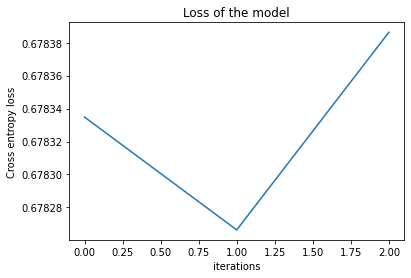

In [116]:
loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
display_loss_plot(loss_per_epoch)

**********************************************************************************************************************

# Add last layer which transforms the output to {-1,1} 

In [117]:
# save the state_dict
model.eval()
path = "quantized_mlp_unsw_nb15.pt"
torch.save(model.state_dict(), path)

In [124]:
# load the state_dict and create new model with aditional QuantIdentity layer
new_model_to_be = QuantLeNet(input_size, hidden1, hidden2, hidden3, num_classes)
new_model_to_be.load_state_dict(torch.load(path))  
new_model_to_be.eval()

class extended_model(nn.Module):
    def __init__(self, my_pretrained_model):
        super(extended_model, self).__init__()
        self.pretrained = my_pretrained_model
        self.identity = QuantIdentity(act_quant=CommonActQuant,bit_width=act_bit_width)
    
    def forward(self, x):
        out_original = self.pretrained(x)
        out_adjusted = out_original - 0.5
        out_final = self.identity(out_adjusted)
        return out_final


new_model = extended_model(my_pretrained_model=new_model_to_be)
new_model_output = new_model.forward(test_quantized_dataset.data[:,:-1])
new_model_output = new_model_output.detach().numpy()
new_model_output

array([[-1.],
       [-1.],
       [-1.],
       ...,
       [-1.],
       [-1.],
       [-1.]], dtype=float32)

In [122]:
torch.mean(new_model_output)

tensor(-0.9156, grad_fn=<MeanBackward0>)

In [123]:
old_model_output = torch.sigmoid(model.forward(test_quantized_dataset.data[:,:-1])).detach().numpy()
old_model_output = np.round(old_model_output) 
old_model_output = old_model_output*2 -1
old_model_output

array([[ 1.],
       [ 1.],
       [ 1.],
       ...,
       [-1.],
       [-1.],
       [ 1.]], dtype=float32)

In [125]:
np.isclose(old_model_output, new_model_output, atol=1e-1).sum()

38031

# Create files to verify the model after Brevitas export

In [ ]:
model.eval()
raw_output = model.forward(test_quantized_dataset.data[:,:-1])
np.savetxt("brevitas_1_bit_model_no_sigmoid.csv", raw_output.detach().numpy(), delimiter=",")
raw_output

# Export Brevitas model

In [ ]:
#do not change this order
import onnx 
import torch 
import brevitas.onnx as bo

export_onnx_path = "brevitas_w%d_a%-uNSW_NB15_model.onnx" % (weight_bit_width, act_bit_width)
#export_onnx_path = "brevitas1BitUnswnb15.onnx"
input_shape = (2287, 593)
bo.export_finn_onnx(model, input_shape, export_onnx_path)
print("Model saved to %s" % export_onnx_path)